# LLaVA-Med++ Demo
Enhancing Visual Instruction Tuning with LLaMA 3.1 

## Setup

In [4]:
## reduce logging
import logging, sys
logging.getLogger().setLevel(logging.CRITICAL)
logging.disable(sys.maxsize)

In [33]:
#!conda env export --no-builds > environment.yml

In [2]:
## fix warning
## "bash: /miniconda/envs/llava-more/lib/libtinfo.so.6: no version information available (required by bash)"
# conda install -c conda-forge ncurses

# conda install pytorch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 pytorch-cuda=12.1 -c pytorch -c nvidia

import torch
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [3]:
## fix widgets
#!conda install -c conda-forge ipywidgets -y
#!jupyter nbextension enable --py widgetsnbextension

In [4]:
# conda install pytorch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 pytorch-cuda=12.1 -c pytorch -c nvidia
#!pip uninstall flash-attn -y
#!pip install flash-attn --no-build-isolation
#!pip install ipywidgets
#!pip install transformers==4.44.2
#!pip install scipy
#!pip install python-dotenv

#!pip install datasets
#!pip install accelerate
#!pip install git+https://github.com/bfshi/scaling_on_scales.git

# from huggingface_hub import notebook_login
# notebook_login()

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Feb__7_19:32:13_PST_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [6]:
!python --version

Python 3.10.14


In [7]:
import transformers
print("transformers = ",transformers.__version__)
import torch
print ("torch =", torch.__version__)

transformers =  4.44.2
torch = 2.3.1


/miniconda/envs/llava-med++/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
!pwd

/home/pop/hosting/medical/MedTrinity-25M


In [9]:
%load_ext dotenv
%dotenv

## Evaluation

In [2]:
##%tb
import argparse
import torch
import requests
from PIL import Image
from io import BytesIO
import re

from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

def image_parser(args):
    out = args.image_file.split(args.sep)
    return out


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

def eval_model(args):
    # Model
    disable_torch_init()

    model_name = get_model_name_from_path(args.model_path)
    model_name= 'llava'

    tokenizer, model, image_processor, context_len = load_pretrained_model(
        args.model_path, args.model_base, model_name, load_8bit=False
    )
    #print(model.config)
    
    qs = args.query
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in qs:
        if model.config.mm_use_im_start_end:
            qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
        else:
            qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
    else:
        if model.config.mm_use_im_start_end:
            qs = image_token_se + "\n" + qs
        else:
            qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

    if "llama-2" in model_name.lower():
        conv_mode = "llava_llama_2"
    elif "mistral" in model_name.lower():
        conv_mode = "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        conv_mode = "chatml_direct"
    elif "v1" in model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    if args.conv_mode is not None and conv_mode != args.conv_mode:
        print(
            "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
                conv_mode, args.conv_mode, args.conv_mode
            )
        )
    else:
        args.conv_mode = conv_mode
    
    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    conv.tokenizer = tokenizer

    image_files = image_parser(args)
    images = load_images(image_files)
    image_sizes = [x.size for x in images]
    images_tensor = process_images(
        images,
        image_processor,
        model.config
    ).to(model.device, dtype=torch.float16)

    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .cuda()
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature,
            top_p=args.top_p,
            num_beams=args.num_beams,
            max_new_tokens=args.max_new_tokens,
            use_cache=True,
        )

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    #print(outputs)
    return outputs

/miniconda/envs/llava-med++/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## demo dataset

In [11]:
from datasets import load_dataset

ds = load_dataset("UCSC-VLAA/MedTrinity-25M", "25M_demo")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'caption'],
        num_rows: 161630
    })
})

In [12]:
ds["train"][2000]['id']

'80306b2e-1b5c-11ef-af70-000066532cad'

In [13]:
ds["train"][2000]['caption']

"The image is a non-contrast computed tomography (CT) scan of the brain, showing the cerebral structures without the use of contrast media. The region of interest, located centrally and in the lower-middle area of the brain, occupies approximately 0.5% of the image area and is indicative of an intracranial hemorrhage. This region appears denser than the surrounding brain tissue, which is a characteristic feature of acute hemorrhage on CT imaging. The location of the hemorrhage could potentially affect nearby brain structures due to mass effect or increased intracranial pressure, although the image does not provide evidence of such complications. The hemorrhage's proximity to critical brain areas suggests a possible impact on the patient's neurological function."

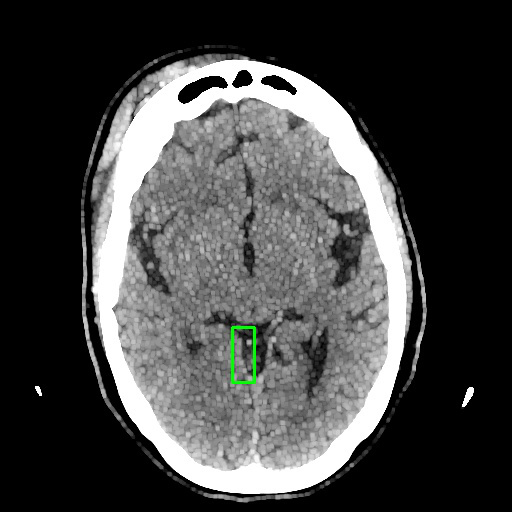

In [14]:
im=ds["train"][2000]['image']
im

In [15]:
# save a image using extension
#out_im = Image.fromarray(im)
im.save('med_test_2000.png')

## Test-1 VGA RAD

In [16]:
from IPython.display import display
path="https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg"
#display(Image.open(path))
#Image(url= path, width=100, height=100)
from IPython.core.display import Image, display
display(Image(url=path, width=600, height=100, unconfined=True))

/tmp/ipykernel_153409/4283171320.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [17]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift"    
    #model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift_20240817"
    model_base: int = None
    image_file:str = "https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg"
    query: str = "What Do Chest X-Rays Show?"
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = 3
    num_beams: int = 3
    max_new_tokens: int = 256
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result = eval_model(args)

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 23.3 s, sys: 21.3 s, total: 44.6 s
Wall time: 10.6 s


In [18]:
result

'cardiomegaly'

## Test-2 PathVGA

In [19]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetune-pathvqa_orift/"    
    #model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift_20240817"
    model_base: int = None
    image_file:str = "https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg"    
    query: str = "What Do Chest X-Rays Show?"
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = 3
    num_beams: int = 3
    max_new_tokens: int = 256
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
result = eval_model(args)

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetune-pathvqa_orift/
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 25.3 s, sys: 21.4 s, total: 46.8 s
Wall time: 21.7 s


In [20]:
result

'aorta not opened surrounded by large nodes'

## Test-3 Captioner

In [21]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner"    
    #model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift_20240817"
    model_base: int = None
    image_file:str = "https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg"    
    #image_file:str = "https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-022-27266-9/MediaObjects/41598_2022_27266_Fig1_HTML.png"
    #image_file: str = "med_test_2000.png"    
    query: str = "Give me detailed description of the image, based on coarse caption, lesion region, medical knowledge"
    #query: str = "What is abnormal show in the X-Ray?"    
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = None
    num_beams: int = 3
    max_new_tokens: int = 1024
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result=eval_model(args)

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.25s/it]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 32.4 s, sys: 20.3 s, total: 52.7 s
Wall time: 20.8 s


In [22]:
result

"The image is a chest X-ray showing the thoracic cavity, including the lungs, heart, and the bony structures such as the ribs and the spine. A region of interest is located at left part of the image horizontally and middle part of image vertically, occupying approximately 18.5% of the total area. The lungs are the primary organs visible, with the heart situated centrally between them. The left lung is on the right side of the image, and the right lung is on the left side due to the perspective of the X-ray. There are no medical devices visible in the image.\n\nThe region of interest is located in the left lung, which is on the right side of the image from the viewer's perspective. This area shows an abnormal texture and possibly a difference in density compared to the surrounding lung tissue, which may indicate a lesion or other pathological change.\n\nThe abnormal area within the region of interest could be related to the surrounding lung tissue in terms of pathology, as diseases of t

## Test 4 Slake
https://www.topdoctors.co.uk/medical-dictionary/pneumonia

In [23]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    #model_path: str = "/home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner"    
    model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetune-slake_orift"
    model_base: int = None
    image_file:str = "https://www.topdoctors.co.uk/files/Image/large/5a536fd0-0d70-4b1d-be00-3c8e25bbab96.jpg"
    #image_file: str = "med_test_2000.png"    
    #query: str = "What Do Chest X-Rays Show?"
    query: str = "Anything abnormal in the Chest X-Ray?"    
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = 3
    num_beams: int = 3
    max_new_tokens: int = 256
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result=eval_model(args)

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetune-slake_orift
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.73s/it]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 18.3 s, sys: 28.9 s, total: 47.2 s
Wall time: 14.2 s


In [24]:
result

'Yes'

## Test 5 Captioner

In [25]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner"    
    #model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift_20240817"
    model_base: int = None
    #image_file:str = "https://www.topdoctors.co.uk/files/Image/large/5a536fd0-0d70-4b1d-be00-3c8e25bbab96.jpg"
    image_file: str = "med_test_2000.png"    
    #query: str = "What Do Chest X-Rays Show?"
    query: str = "Give me detailed description of the image, based on coarse caption, lesion region, medical knowledge"    
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = None
    num_beams: int = 1
    max_new_tokens: int = 1024
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result = eval_model(args)

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 26.3 s, sys: 12.2 s, total: 38.5 s
Wall time: 13.9 s


In [31]:
print(result)

None


## Test 6 Slake

In [40]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetune-slake_orift"    
    #model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift_20240817"
    model_base: int = None
    image_file:str = "https://www.topdoctors.co.uk/files/Image/large/5a536fd0-0d70-4b1d-be00-3c8e25bbab96.jpg"
    #image_file: str = "med_test_2000.png"    
    #query: str = "What Do Chest X-Rays Show?"
    query: str = "provide a detail description for this photo without interpretations"    
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = None
    num_beams: int = 1
    max_new_tokens: int = 1024
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result = eval_model(args)

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetune-slake_orift
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 15.5 s, sys: 11.5 s, total: 27 s
Wall time: 8.41 s


In [41]:
result

'X-Ray'

## Test 7 Default

In [5]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/LLaVA-Meta-Llama-3-8B-Instruct-FT-S2"    
    model_base: int = None
    image_file:str = "https://www.topdoctors.co.uk/files/Image/large/5a536fd0-0d70-4b1d-be00-3c8e25bbab96.jpg"
    #image_file: str = "med_test_2000.png"    
    #query: str = "What Do Chest X-Rays Show?"
    query: str = "provide a detail description for this photo without interpretations"    
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = None
    num_beams: int = 1
    max_new_tokens: int = 1024
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result = eval_model(args)
result

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/LLaVA-Meta-Llama-3-8B-Instruct-FT-S2
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 1min 32s, sys: 20.8 s, total: 1min 53s
Wall time: 1min 15s


"The image features an X-ray of a person's chest area, showing the individual's rib cage and the organs surrounding it. The x-ray clearly highlights the rib cage, which consists of numerous bones covering the chest area. This detailed structure view provides insight into the human anatomy and can be helpful for medical purposes."

In [30]:
#cd MedTrinity-25M
#!bash ./scripts/med/llava3_med_eval_batch_vqa_rad.sh

In [6]:
%%time
from dataclasses import dataclass
from PIL import Image

@dataclass
class Inputs():
    model_path: str = "/home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner"    
    #model_path: str = "/home/pop/hosting/medical/med-model/llava-llama-med-8b-stage2-finetuned-vga_rad_orift_20240817"
    model_base: int = None
    image_file:str = "https://www.topdoctors.co.uk/files/Image/large/5a536fd0-0d70-4b1d-be00-3c8e25bbab96.jpg"
    #query: str = "What Do Chest X-Rays Show?"
    query: str = "Give me detailed description of the image, based on coarse caption, lesion region, medical knowledge"    
    conv_mode: str = "llama3"
    sep: str = ","
    temperature: float = 1.0
    top_p:int = None
    num_beams: int = 1
    max_new_tokens: int = 1024
    
args = Inputs()
print(f"conversation mode: {args.conv_mode}")
print(f"model name: {args.model_path}")
    
result = eval_model(args)
result

conversation mode: llama3
model name: /home/pop/hosting/medical/med-model/LLaVA-Med-Captioner/llava-llama-med-8b-captioner
vision_tower openai/clip-vit-large-patch14-336, is_absolute_path_exists: False, load_delay: True
delay load: True
delay load and just load the config, is_loaded: False


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


Adding pad token as '<pad>'
tokenizer's pad token id is:  128256
[WARNING] the auto inferred conversation mode is llava_v0, while `--conv-mode` is llama3, using llama3
CPU times: user 53.4 s, sys: 18 s, total: 1min 11s
Wall time: 16.3 s


'The image is a chest X-ray showing the heart, diaphragm, and the majority of the lungs. A region of interest is located at left-center part of the image horizontally and middle part of image vertically, occupying approximately 24.7% of the total area. The heart is located centrally and slightly to the left, with the diaphragm beneath it. The lungs are the primary organs visible, with the left lung appearing on the right side of the image and the right lung on the left side due to the perspective of the X-ray. There are no medical lesions visible in the image.\n\nThe region of interest, indicated by the annotation, is located within the right lung and appears as an area with abnormal texture and possibly altered density compared to the surrounding lung tissue. This could suggest the presence of a pathological condition such as a mass, consolidation, or other lung lesion.\n\nThe abnormal region within the right lung may be related to the surrounding lung tissue in terms of its impact on